# Entrenamiento del Modelo - Perceptrón Multicapa

En este notebook implementaremos un Perceptrón Multicapa (MLP) desde cero para el dataset de Wisconsin Breast Cancer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime
import pickle

## 1. Carga de datos normalizados

Cargaremos los conjuntos de datos preparados en el notebook anterior.

In [2]:
# Rutas a los datos procesados
processed_dir = "../data/processed"
output_dir = "../output"
model_dir = "../output/models"

# Crear directorio para modelos si no existe
os.makedirs(model_dir, exist_ok=True)

# Cargar datos de entrenamiento y prueba
train_data = pd.read_csv(f"{processed_dir}/train_normalized.csv")
test_data = pd.read_csv(f"{processed_dir}/test_normalized.csv")

# Separar características y etiquetas
X_train = train_data.iloc[:, 1:].values  # Todas las columnas excepto 'diagnosis'
y_train = train_data.iloc[:, 0].values   # Solo la columna 'diagnosis'

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

# Dimensiones de los datos
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras x {X_train.shape[1]} características")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras x {X_test.shape[1]} características")

Conjunto de entrenamiento: 456 muestras x 30 características
Conjunto de prueba: 113 muestras x 30 características


## 2. Implementación del Perceptrón Multicapa

Vamos a implementar el MLP de manera modular, utilizando clases para las diferentes partes del modelo.

### 2.1 Funciones de activación

Primero, implementamos las funciones de activación y sus derivadas.

In [3]:
class Activation:
    @staticmethod
    def sigmoid(x):
        """Función sigmoide: f(x) = 1 / (1 + e^(-x))"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip para evitar desbordamientos
    
    @staticmethod
    def sigmoid_derivative(x):
        """Derivada de la función sigmoide: f'(x) = f(x) * (1 - f(x))"""
        s = Activation.sigmoid(x)
        return s * (1 - s)
    
    @staticmethod
    def tanh(x):
        """Función tangente hiperbólica: f(x) = tanh(x)"""
        return np.tanh(x)
    
    @staticmethod
    def tanh_derivative(x):
        """Derivada de la función tangente hiperbólica: f'(x) = 1 - tanh(x)^2"""
        t = np.tanh(x)
        return 1 - t**2
    
    @staticmethod
    def relu(x):
        """Función ReLU: f(x) = max(0, x)"""
        return np.maximum(0, x)
    
    @staticmethod
    def relu_derivative(x):
        """Derivada de la función ReLU: f'(x) = 1 si x > 0, 0 en otro caso"""
        return np.where(x > 0, 1, 0)
    
    @staticmethod
    def leaky_relu(x, alpha=0.01):
        """Función Leaky ReLU: f(x) = max(alpha*x, x)"""
        return np.maximum(alpha * x, x)
    
    @staticmethod
    def leaky_relu_derivative(x, alpha=0.01):
        """Derivada de la función Leaky ReLU: f'(x) = 1 si x > 0, alpha en otro caso"""
        return np.where(x > 0, 1, alpha)
    
    @staticmethod
    def softmax(x):
        """Función Softmax: f(x_i) = e^x_i / sum(e^x_j)"""
        # Restar el máximo para estabilidad numérica
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    @staticmethod
    def identity(x):
        """Función identidad: f(x) = x"""
        return x
    
    @staticmethod
    def identity_derivative(x):
        """Derivada de la función identidad: f'(x) = 1"""
        return np.ones_like(x)

### 2.2 Funciones de pérdida

A continuación, implementamos las funciones de pérdida y sus derivadas.

In [4]:
class Loss:
    @staticmethod
    def mse(y_true, y_pred):
        """Error cuadrático medio: L = (1/n) * sum((y_true - y_pred)^2)"""
        return np.mean(np.square(y_true - y_pred))
    
    @staticmethod
    def mse_derivative(y_true, y_pred):
        """Derivada del error cuadrático medio: dL/dy_pred = -2 * (y_true - y_pred) / n"""
        return -2 * (y_true - y_pred) / y_true.shape[0]
    
    @staticmethod
    def binary_crossentropy(y_true, y_pred):
        """
        Entropía cruzada binaria: L = -(1/n) * sum(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
        """
        # Agregar un pequeño epsilon para evitar log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    @staticmethod
    def binary_crossentropy_derivative(y_true, y_pred):
        """
        Derivada de la entropía cruzada binaria: 
        dL/dy_pred = (y_pred - y_true) / (y_pred * (1 - y_pred))
        """
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return (y_pred - y_true) / (y_pred * (1 - y_pred) * y_true.shape[0])
    
    @staticmethod
    def categorical_crossentropy(y_true, y_pred):
        """
        Entropía cruzada categórica: L = -(1/n) * sum(sum(y_true * log(y_pred)))
        """
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    @staticmethod
    def categorical_crossentropy_derivative(y_true, y_pred):
        """
        Derivada de la entropía cruzada categórica: dL/dy_pred = -y_true / y_pred
        """
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -y_true / (y_pred * y_true.shape[0])

### 2.3 Inicialización de pesos

Implementamos diferentes métodos para inicializar los pesos de la red.

In [5]:
class WeightInitializer:
    @staticmethod
    def random(input_size, output_size):
        """Inicialización aleatoria de pesos entre -0.5 y 0.5"""
        return np.random.uniform(-0.5, 0.5, (input_size, output_size))
    
    @staticmethod
    def xavier_uniform(input_size, output_size):
        """
        Inicialización Xavier/Glorot uniforme:
        Rango: [-sqrt(6/(input_size + output_size)), sqrt(6/(input_size + output_size))]
        """
        limit = np.sqrt(6 / (input_size + output_size))
        return np.random.uniform(-limit, limit, (input_size, output_size))
    
    @staticmethod
    def xavier_normal(input_size, output_size):
        """
        Inicialización Xavier/Glorot normal:
        Desviación: sqrt(2/(input_size + output_size))
        """
        stddev = np.sqrt(2 / (input_size + output_size))
        return np.random.normal(0, stddev, (input_size, output_size))
    
    @staticmethod
    def he_uniform(input_size, output_size):
        """
        Inicialización He uniforme:
        Rango: [-sqrt(6/input_size), sqrt(6/input_size)]
        """
        limit = np.sqrt(6 / input_size)
        return np.random.uniform(-limit, limit, (input_size, output_size))
    
    @staticmethod
    def he_normal(input_size, output_size):
        """
        Inicialización He normal:
        Desviación: sqrt(2/input_size)
        """
        stddev = np.sqrt(2 / input_size)
        return np.random.normal(0, stddev, (input_size, output_size))
    
    @staticmethod
    def zeros(input_size, output_size):
        """Inicialización con ceros"""
        return np.zeros((input_size, output_size))

### 2.4 Capa densa (Fully Connected)

Ahora implementamos la capa densa (fully connected) de la red neuronal.

In [6]:
class DenseLayer:
    def __init__(self, input_size, output_size, activation="sigmoid", weights_initializer="he_uniform"):
        """
        Inicializa una capa densa.
        
        Parámetros:
        input_size (int): Número de neuronas de entrada
        output_size (int): Número de neuronas de salida
        activation (str): Función de activación a utilizar
        weights_initializer (str): Método de inicialización de pesos
        """
        self.input_size = input_size
        self.output_size = output_size
        
        # Inicializar pesos y bias
        self.weights_initializer = weights_initializer
        self.init_weights()
        
        # Configurar función de activación
        self.activation_name = activation
        self.set_activation(activation)
        
        # Valores para el entrenamiento
        self.input = None
        self.output = None
        self.delta = None
        
        # Para optimizadores con momento o adaptabilidad
        self.velocity_w = np.zeros_like(self.weights)
        self.velocity_b = np.zeros_like(self.bias)
        self.cache_w = np.zeros_like(self.weights)
        self.cache_b = np.zeros_like(self.bias)
    
    def init_weights(self):
        """Inicializa los pesos y bias según el método especificado"""
        initializers = {
            "random": WeightInitializer.random,
            "xavier_uniform": WeightInitializer.xavier_uniform,
            "xavier_normal": WeightInitializer.xavier_normal,
            "he_uniform": WeightInitializer.he_uniform,
            "he_normal": WeightInitializer.he_normal,
            "zeros": WeightInitializer.zeros
        }
        
        init_func = initializers.get(self.weights_initializer.lower(), WeightInitializer.he_uniform)
        self.weights = init_func(self.input_size, self.output_size)
        self.bias = np.zeros((1, self.output_size))
    
    def set_activation(self, activation):
        """Configura la función de activación y su derivada"""
        activation_funcs = {
            "sigmoid": (Activation.sigmoid, Activation.sigmoid_derivative),
            "tanh": (Activation.tanh, Activation.tanh_derivative),
            "relu": (Activation.relu, Activation.relu_derivative),
            "leaky_relu": (Activation.leaky_relu, Activation.leaky_relu_derivative),
            "softmax": (Activation.softmax, None),  # La derivada se maneja de forma especial
            "identity": (Activation.identity, Activation.identity_derivative)
        }
        
        if activation.lower() in activation_funcs:
            self.activation, self.activation_derivative = activation_funcs[activation.lower()]
        else:
            print(f"Función de activación '{activation}' no reconocida. Usando sigmoid por defecto.")
            self.activation, self.activation_derivative = activation_funcs["sigmoid"]
    
    def forward(self, input_data):
        """
        Propagación hacia adelante.
        
        Parámetros:
        input_data (numpy.ndarray): Datos de entrada
        
        Retorna:
        numpy.ndarray: Salida después de aplicar la función de activación
        """
        self.input = input_data
        self.z = np.dot(self.input, self.weights) + self.bias
        
        # Caso especial para softmax que debe aplicarse a toda la capa
        if self.activation_name.lower() == "softmax":
            self.output = Activation.softmax(self.z)
        else:
            self.output = self.activation(self.z)
        
        return self.output
    
    def backward(self, delta, learning_rate=0.01, optimizer="sgd", **kwargs):
        """
        Propagación hacia atrás.
        
        Parámetros:
        delta (numpy.ndarray): Error proveniente de la capa siguiente
        learning_rate (float): Tasa de aprendizaje
        optimizer (str): Optimizador a utilizar
        kwargs: Argumentos adicionales para el optimizador
        
        Retorna:
        numpy.ndarray: Error para la capa anterior
        """
        if self.activation_name.lower() != "softmax":
            # Para funciones de activación comunes
            delta = delta * self.activation_derivative(self.z)
        # Para softmax, el delta ya viene calculado correctamente desde la función de pérdida
        
        # Calcular el error para la capa anterior
        delta_prev = np.dot(delta, self.weights.T)
        
        # Actualizar weights y bias según el optimizador
        self.optimize(delta, learning_rate, optimizer, **kwargs)
        
        return delta_prev
    
    def optimize(self, delta, learning_rate, optimizer, **kwargs):
        """
        Actualiza los pesos y bias utilizando el optimizador especificado.
        
        Parámetros:
        delta (numpy.ndarray): Error de la capa
        learning_rate (float): Tasa de aprendizaje
        optimizer (str): Optimizador a utilizar
        kwargs: Argumentos adicionales para el optimizador
        """
        batch_size = self.input.shape[0]
        
        # Gradientes para weights y bias
        dw = np.dot(self.input.T, delta) / batch_size
        db = np.mean(delta, axis=0, keepdims=True)
        
        if optimizer.lower() == "sgd":
            # Descenso de gradiente estocástico (SGD)
            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db
        
        elif optimizer.lower() == "momentum":
            # SGD con momento
            momentum = kwargs.get("momentum", 0.9)
            self.velocity_w = momentum * self.velocity_w - learning_rate * dw
            self.velocity_b = momentum * self.velocity_b - learning_rate * db
            self.weights += self.velocity_w
            self.bias += self.velocity_b
        
        elif optimizer.lower() == "nesterov":
            # Momento de Nesterov
            momentum = kwargs.get("momentum", 0.9)
            v_prev_w = self.velocity_w.copy()
            v_prev_b = self.velocity_b.copy()
            
            self.velocity_w = momentum * self.velocity_w - learning_rate * dw
            self.velocity_b = momentum * self.velocity_b - learning_rate * db
            
            self.weights += -momentum * v_prev_w + (1 + momentum) * self.velocity_w
            self.bias += -momentum * v_prev_b + (1 + momentum) * self.velocity_b
        
        elif optimizer.lower() == "rmsprop":
            # RMSprop
            decay = kwargs.get("decay", 0.9)
            epsilon = kwargs.get("epsilon", 1e-8)
            
            self.cache_w = decay * self.cache_w + (1 - decay) * np.square(dw)
            self.cache_b = decay * self.cache_b + (1 - decay) * np.square(db)
            
            self.weights -= learning_rate * dw / (np.sqrt(self.cache_w) + epsilon)
            self.bias -= learning_rate * db / (np.sqrt(self.cache_b) + epsilon)
        
        elif optimizer.lower() == "adam":
            # Adam
            beta1 = kwargs.get("beta1", 0.9)
            beta2 = kwargs.get("beta2", 0.999)
            epsilon = kwargs.get("epsilon", 1e-8)
            t = kwargs.get("t", 1)  # Iteración actual
            
            # Actualizar momentos
            self.velocity_w = beta1 * self.velocity_w + (1 - beta1) * dw
            self.velocity_b = beta1 * self.velocity_b + (1 - beta1) * db
            
            # Actualizar cache
            self.cache_w = beta2 * self.cache_w + (1 - beta2) * np.square(dw)
            self.cache_b = beta2 * self.cache_b + (1 - beta2) * np.square(db)
            
            # Corregir el bias
            v_corrected_w = self.velocity_w / (1 - beta1**t)
            v_corrected_b = self.velocity_b / (1 - beta1**t)
            c_corrected_w = self.cache_w / (1 - beta2**t)
            c_corrected_b = self.cache_b / (1 - beta2**t)
            
            # Actualizar pesos
            self.weights -= learning_rate * v_corrected_w / (np.sqrt(c_corrected_w) + epsilon)
            self.bias -= learning_rate * v_corrected_b / (np.sqrt(c_corrected_b) + epsilon)
        
        else:
            # Si no se reconoce el optimizador, usar SGD por defecto
            print(f"Optimizador '{optimizer}' no reconocido. Usando SGD por defecto.")
            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db

### 2.5 Implementación de la red neuronal principal

Ahora implementamos la clase principal del Perceptrón Multicapa.

In [7]:
class MultilayerPerceptron:
    def __init__(self):
        """Inicializa un Perceptrón Multicapa vacío"""
        self.layers = []
        self.loss_func = None
        self.loss_derivative = None
        self.training_loss_history = []
        self.validation_loss_history = []
        self.training_accuracy_history = []
        self.validation_accuracy_history = []
    
    def add_layer(self, layer):
        """
        Agrega una capa a la red.
        
        Parámetros:
        layer (DenseLayer): Capa a agregar
        """
        self.layers.append(layer)
    
    def set_loss(self, loss_name):
        """
        Configura la función de pérdida.
        
        Parámetros:
        loss_name (str): Nombre de la función de pérdida
        """
        loss_funcs = {
            "mse": (Loss.mse, Loss.mse_derivative),
            "binary_crossentropy": (Loss.binary_crossentropy, Loss.binary_crossentropy_derivative),
            "categorical_crossentropy": (Loss.categorical_crossentropy, Loss.categorical_crossentropy_derivative)
        }
        
        if loss_name.lower() in loss_funcs:
            self.loss_func, self.loss_derivative = loss_funcs[loss_name.lower()]
        else:
            print(f"Función de pérdida '{loss_name}' no reconocida. Usando MSE por defecto.")
            self.loss_func, self.loss_derivative = loss_funcs["mse"]
    
    def forward(self, X):
        """
        Propagación hacia adelante en todas las capas.
        
        Parámetros:
        X (numpy.ndarray): Datos de entrada
        
        Retorna:
        numpy.ndarray: Salida de la red
        """
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output
    
    def backward(self, y_true, y_pred, learning_rate, optimizer="sgd", **kwargs):
        """
        Propagación hacia atrás en todas las capas.
        
        Parámetros:
        y_true (numpy.ndarray): Valores verdaderos
        y_pred (numpy.ndarray): Valores predichos
        learning_rate (float): Tasa de aprendizaje
        optimizer (str): Optimizador a utilizar
        kwargs: Argumentos adicionales para el optimizador
        """
        # Calcular el error inicial
        delta = self.loss_derivative(y_true, y_pred)
        
        # Propagar el error hacia atrás en cada capa
        for layer in reversed(self.layers):
            delta = layer.backward(delta, learning_rate, optimizer, **kwargs)
    
    def train_batch(self, X_batch, y_batch, learning_rate, optimizer="sgd", **kwargs):
        """
        Entrena la red en un lote de datos.
        
        Parámetros:
        X_batch (numpy.ndarray): Características del lote
        y_batch (numpy.ndarray): Etiquetas del lote
        learning_rate (float): Tasa de aprendizaje
        optimizer (str): Optimizador a utilizar
        kwargs: Argumentos adicionales para el optimizador
        
        Retorna:
        float: Pérdida en este lote
        """
        # Propagación hacia adelante
        y_pred = self.forward(X_batch)
        
        # Calcular pérdida
        loss = self.loss_func(y_batch, y_pred)
        
        # Propagación hacia atrás
        self.backward(y_batch, y_pred, learning_rate, optimizer, **kwargs)
        
        return loss
    
    def predict(self, X):
        """
        Realiza predicciones con la red entrenada.
        
        Parámetros:
        X (numpy.ndarray): Datos de entrada
        
        Retorna:
        numpy.ndarray: Predicciones
        """
        return self.forward(X)
    
    def predict_classes(self, X, threshold=0.5):
        """
        Predice las clases para datos binarios.
        
        Parámetros:
        X (numpy.ndarray): Datos de entrada
        threshold (float): Umbral para clasificación binaria
        
        Retorna:
        numpy.ndarray: Clases predichas (0 o 1)
        """
        predictions = self.predict(X)
        return (predictions > threshold).astype(int)
    
    def evaluate(self, X, y_true, threshold=0.5):
        """
        Evalúa el rendimiento de la red.
        
        Parámetros:
        X (numpy.ndarray): Datos de entrada
        y_true (numpy.ndarray): Valores verdaderos
        threshold (float): Umbral para clasificación binaria
        
        Retorna:
        dict: Métricas de rendimiento (pérdida, precisión)
        """
        y_pred = self.predict(X)
        loss = self.loss_func(y_true, y_pred)
        
        # Para clasificación binaria
        y_pred_class = (y_pred > threshold).astype(int)
        accuracy = np.mean(y_pred_class == y_true)
        
        return {
            "loss": loss,
            "accuracy": accuracy
        }
    
    def fit(self, X_train, y_train, X_val=None, y_val=None, 
            epochs=100, batch_size=32, learning_rate=0.01, 
            optimizer="sgd", verbose=1, early_stopping=False, 
            patience=10, min_delta=0.001, **kwargs):
        """
        Entrena la red neuronal.
        
        Parámetros:
        X_train (numpy.ndarray): Características de entrenamiento
        y_train (numpy.ndarray): Etiquetas de entrenamiento
        X_val (numpy.ndarray): Características de validación
        y_val (numpy.ndarray): Etiquetas de validación
        epochs (int): Número de épocas
        batch_size (int): Tamaño del lote
        learning_rate (float): Tasa de aprendizaje
        optimizer (str): Optimizador a utilizar
        verbose (int): Nivel de detalle de la salida
        early_stopping (bool): Si se usa parada temprana
        patience (int): Número de épocas para parada temprana
        min_delta (float): Cambio mínimo para considerar mejora
        kwargs: Argumentos adicionales para el optimizador
        
        Retorna:
        dict: Historial de entrenamiento
        """
        n_samples = X_train.shape[0]
        
        # Reiniciar historiales
        self.training_loss_history = []
        self.validation_loss_history = []
        self.training_accuracy_history = []
        self.validation_accuracy_history = []
        
        # Para parada temprana
        best_val_loss = float('inf')
        patience_counter = 0
        
        # Iterar sobre las épocas
        for epoch in range(epochs):
            # Mezclar los datos de entrenamiento
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            # Entrenar por lotes
            epoch_loss = 0
            n_batches = int(np.ceil(n_samples / batch_size))
            
            for batch in range(n_batches):
                start = batch * batch_size
                end = min(start + batch_size, n_samples)
                
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                
                # Convertir y_batch a formato adecuado (columna)
                if len(y_batch.shape) == 1:
                    y_batch = y_batch.reshape(-1, 1)
                
                # Entrenar este lote
                t = epoch * n_batches + batch + 1  # Iteración actual para Adam
                batch_loss = self.train_batch(X_batch, y_batch, learning_rate, optimizer, t=t, **kwargs)
                epoch_loss += batch_loss
            
            # Calcular pérdida y precisión promedio de la época
            epoch_loss /= n_batches
            self.training_loss_history.append(epoch_loss)
            
            # Evaluar en conjunto de entrenamiento
            train_metrics = self.evaluate(X_train, y_train.reshape(-1, 1))
            self.training_accuracy_history.append(train_metrics["accuracy"])
            
            # Evaluar en conjunto de validación si se proporciona
            val_metrics = {"loss": None, "accuracy": None}
            if X_val is not None and y_val is not None:
                val_metrics = self.evaluate(X_val, y_val.reshape(-1, 1))
                self.validation_loss_history.append(val_metrics["loss"])
                self.validation_accuracy_history.append(val_metrics["accuracy"])
                
                # Parada temprana
                if early_stopping:
                    if val_metrics["loss"] < best_val_loss - min_delta:
                        best_val_loss = val_metrics["loss"]
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            if verbose > 0:
                                print(f"\nParada temprana en época {epoch+1}")
                            break
            
            # Imprimir progreso
            if verbose > 0 and (epoch % max(1, epochs // 10) == 0 or epoch == epochs - 1):
                val_loss_str = f"- val_loss: {val_metrics['loss']:.4f}" if val_metrics["loss"] is not None else ""
                val_acc_str = f"- val_acc: {val_metrics['accuracy']:.4f}" if val_metrics["accuracy"] is not None else ""
                print(f"Época {epoch+1}/{epochs} - loss: {epoch_loss:.4f} - acc: {train_metrics['accuracy']:.4f} {val_loss_str} {val_acc_str}")
        
        if verbose > 0:
            print("\nEntrenamiento completado.")
        
        return {
            "training_loss": self.training_loss_history,
            "validation_loss": self.validation_loss_history,
            "training_accuracy": self.training_accuracy_history,
            "validation_accuracy": self.validation_accuracy_history
        }
    
    def save(self, filepath):
        """
        Guarda el modelo en un archivo.
        
        Parámetros:
        filepath (str): Ruta donde guardar el modelo
        """
        # Crear un diccionario con la estructura y pesos del modelo
        model_data = {
            "architecture": [
                {
                    "type": "DenseLayer",
                    "input_size": layer.input_size,
                    "output_size": layer.output_size,
                    "activation": layer.activation_name,
                    "weights_initializer": layer.weights_initializer,
                    "weights": layer.weights.tolist(),
                    "bias": layer.bias.tolist()
                } for layer in self.layers
            ],
            "loss": self.loss_func.__name__ if hasattr(self.loss_func, "__name__") else None,
            "history": {
                "training_loss": self.training_loss_history,
                "validation_loss": self.validation_loss_history,
                "training_accuracy": self.training_accuracy_history,
                "validation_accuracy": self.validation_accuracy_history
            },
            "metadata": {
                "creation_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            }
        }
        
        # Guardar como archivo pickle
        with open(filepath, "wb") as f:
            pickle.dump(model_data, f)
        
        print(f"Modelo guardado en: {filepath}")
    
    @classmethod
    def load(cls, filepath):
        """
        Carga un modelo desde un archivo.
        
        Parámetros:
        filepath (str): Ruta del archivo del modelo
        
        Retorna:
        MultilayerPerceptron: Modelo cargado
        """
        # Cargar el diccionario del modelo
        with open(filepath, "rb") as f:
            model_data = pickle.load(f)
        
        # Crear un nuevo modelo
        model = cls()
        
        # Configurar la función de pérdida
        if model_data.get("loss"):
            model.set_loss(model_data["loss"])
        
        # Recrear las capas
        for layer_data in model_data["architecture"]:
            if layer_data["type"] == "DenseLayer":
                layer = DenseLayer(
                    input_size=layer_data["input_size"],
                    output_size=layer_data["output_size"],
                    activation=layer_data["activation"],
                    weights_initializer=layer_data["weights_initializer"]
                )
                
                # Cargar pesos y bias
                layer.weights = np.array(layer_data["weights"])
                layer.bias = np.array(layer_data["bias"])
                
                # Agregar la capa al modelo
                model.add_layer(layer)
        
        # Cargar historial si existe
        if "history" in model_data:
            model.training_loss_history = model_data["history"].get("training_loss", [])
            model.validation_loss_history = model_data["history"].get("validation_loss", [])
            model.training_accuracy_history = model_data["history"].get("training_accuracy", [])
            model.validation_accuracy_history = model_data["history"].get("validation_accuracy", [])
        
        return model

### 2.6 Función para crear una red con configuración específica

Implementamos una función auxiliar para crear una red con una configuración específica.

In [8]:
def create_mlp(input_size, output_size, hidden_layers=2, neurons_per_layer=25,
               activation="sigmoid", output_activation="sigmoid", 
               weights_initializer="he_uniform", loss="binary_crossentropy"):
    """
    Crea un Perceptrón Multicapa con la configuración especificada.
    
    Parámetros:
    input_size (int): Tamaño de la capa de entrada
    output_size (int): Tamaño de la capa de salida
    hidden_layers (int): Número de capas ocultas
    neurons_per_layer (int): Número de neuronas por capa oculta
    activation (str): Función de activación para las capas ocultas
    output_activation (str): Función de activación para la capa de salida
    weights_initializer (str): Método de inicialización de pesos
    loss (str): Función de pérdida
    
    Retorna:
    MultilayerPerceptron: Modelo configurado
    """
    model = MultilayerPerceptron()
    
    # Capa de entrada a primera capa oculta
    model.add_layer(DenseLayer(
        input_size=input_size,
        output_size=neurons_per_layer,
        activation=activation,
        weights_initializer=weights_initializer
    ))
    
    # Capas ocultas adicionales
    for _ in range(hidden_layers - 1):
        model.add_layer(DenseLayer(
            input_size=neurons_per_layer,
            output_size=neurons_per_layer,
            activation=activation,
            weights_initializer=weights_initializer
        ))
    
    # Capa de salida
    model.add_layer(DenseLayer(
        input_size=neurons_per_layer,
        output_size=output_size,
        activation=output_activation,
        weights_initializer=weights_initializer
    ))
    
    # Configurar la función de pérdida
    model.set_loss(loss)
    
    return model

## 3. Entrenamiento del Modelo

Ahora vamos a entrenar nuestro Perceptrón Multicapa con los datos normalizados.

### 3.1 Configuración de hiperparámetros

Definimos los hiperparámetros para el entrenamiento del modelo.

In [9]:
# Parámetros del modelo
input_size = X_train.shape[1]  # Número de características (30)
output_size = 1                # Problema de clasificación binaria (1 neurona de salida)
hidden_layers = 2              # Número de capas ocultas
neurons_per_layer = 25         # Neuronas por capa oculta
activation = "sigmoid"         # Función de activación para capas ocultas
output_activation = "sigmoid"  # Función de activación para capa de salida
weights_initializer = "he_uniform"  # Inicialización de pesos
loss = "binary_crossentropy"   # Función de pérdida

# Parámetros de entrenamiento
epochs = 100                   # Épocas de entrenamiento
batch_size = 32                # Tamaño del lote
learning_rate = 0.01           # Tasa de aprendizaje
optimizer = "adam"             # Optimizador
early_stopping = True          # Parada temprana
patience = 10                  # Paciencia para parada temprana

# Parámetros para optimizadores
optimizer_params = {
    "momentum": 0.9,           # Para momentum y nesterov
    "beta1": 0.9,              # Para adam
    "beta2": 0.999,            # Para adam
    "epsilon": 1e-8,           # Para rmsprop y adam
    "decay": 0.9               # Para rmsprop
}

# Imprimir configuración
print("\nConfiguración del modelo:")
print(f"- Entrada: {input_size} neuronas")
print(f"- Capas ocultas: {hidden_layers} con {neurons_per_layer} neuronas cada una")
print(f"- Salida: {output_size} neurona(s)")
print(f"- Activación (ocultas): {activation}")
print(f"- Activación (salida): {output_activation}")
print(f"- Inicialización de pesos: {weights_initializer}")
print(f"- Función de pérdida: {loss}")
print("\nConfiguración de entrenamiento:")
print(f"- Épocas: {epochs}")
print(f"- Tamaño de lote: {batch_size}")
print(f"- Tasa de aprendizaje: {learning_rate}")
print(f"- Optimizador: {optimizer}")
print(f"- Early stopping: {'Activado (paciencia: ' + str(patience) + ')' if early_stopping else 'Desactivado'}")


Configuración del modelo:
- Entrada: 30 neuronas
- Capas ocultas: 2 con 25 neuronas cada una
- Salida: 1 neurona(s)
- Activación (ocultas): sigmoid
- Activación (salida): sigmoid
- Inicialización de pesos: he_uniform
- Función de pérdida: binary_crossentropy

Configuración de entrenamiento:
- Épocas: 100
- Tamaño de lote: 32
- Tasa de aprendizaje: 0.01
- Optimizador: adam
- Early stopping: Activado (paciencia: 10)


### 3.2 Crear y entrenar el modelo

In [10]:
# Crear el modelo
model = create_mlp(
    input_size=input_size,
    output_size=output_size,
    hidden_layers=hidden_layers,
    neurons_per_layer=neurons_per_layer,
    activation=activation,
    output_activation=output_activation,
    weights_initializer=weights_initializer,
    loss=loss
)

print("\nIniciando entrenamiento...\n")

# Entrenar el modelo
history = model.fit(
    X_train=X_train,
    y_train=y_train,
    X_val=X_test,  # Usamos el conjunto de test como validación
    y_val=y_test,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    optimizer=optimizer,
    early_stopping=early_stopping,
    patience=patience,
    verbose=1,
    **optimizer_params
)


Iniciando entrenamiento...

Época 1/100 - loss: 0.5486 - acc: 0.9276 - val_loss: 0.3090 - val_acc: 0.9469
Época 11/100 - loss: 0.0560 - acc: 0.9868 - val_loss: 0.0582 - val_acc: 0.9823

Parada temprana en época 16

Entrenamiento completado.


### 3.3 Evaluar el modelo entrenado

Evaluamos el rendimiento del modelo en los conjuntos de entrenamiento y prueba.

In [11]:
# Evaluar en conjunto de entrenamiento
train_metrics = model.evaluate(X_train, y_train.reshape(-1, 1))
print("\nEvaluación en conjunto de entrenamiento:")
print(f"- Pérdida: {train_metrics['loss']:.4f}")
print(f"- Precisión: {train_metrics['accuracy']:.4f}")

# Evaluar en conjunto de prueba
test_metrics = model.evaluate(X_test, y_test.reshape(-1, 1))
print("\nEvaluación en conjunto de prueba:")
print(f"- Pérdida: {test_metrics['loss']:.4f}")
print(f"- Precisión: {test_metrics['accuracy']:.4f}")


Evaluación en conjunto de entrenamiento:
- Pérdida: 0.0492
- Precisión: 0.9868

Evaluación en conjunto de prueba:
- Pérdida: 0.0585
- Precisión: 0.9823


### 3.4 Visualizar el progreso del entrenamiento

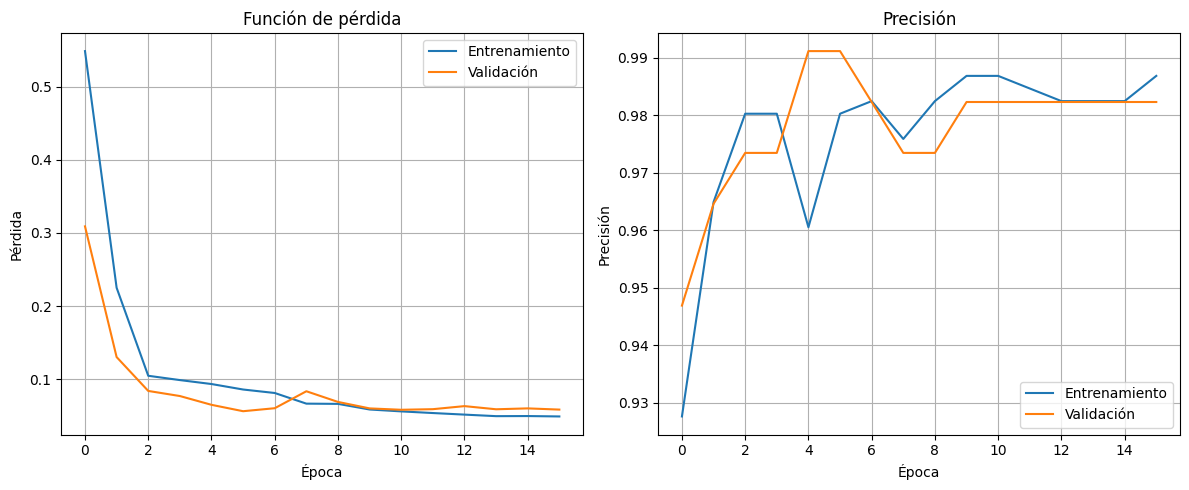

In [12]:
# Crear figura para mostrar las gráficas
plt.figure(figsize=(12, 5))

# Gráfica de pérdida
plt.subplot(1, 2, 1)
plt.plot(history["training_loss"], label="Entrenamiento")
if history["validation_loss"]:
    plt.plot(history["validation_loss"], label="Validación")
plt.title("Función de pérdida")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)

# Gráfica de precisión
plt.subplot(1, 2, 2)
plt.plot(history["training_accuracy"], label="Entrenamiento")
if history["validation_accuracy"]:
    plt.plot(history["validation_accuracy"], label="Validación")
plt.title("Precisión")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{output_dir}/figures/training_history.png", dpi=300, bbox_inches="tight")
plt.show()

### 3.5 Guardar el modelo entrenado

In [13]:
# Crear nombre para el modelo con timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"mlp_{hidden_layers}layers_{neurons_per_layer}neurons_{optimizer}_{timestamp}.pkl"
model_path = os.path.join(model_dir, model_filename)

# Guardar el modelo
model.save(model_path)

# Guardar un resumen de la configuración
config_summary = {
    "model_name": model_filename,
    "architecture": {
        "input_size": input_size,
        "hidden_layers": hidden_layers,
        "neurons_per_layer": neurons_per_layer,
        "output_size": output_size,
        "activation": activation,
        "output_activation": output_activation,
        "weights_initializer": weights_initializer
    },
    "training": {
        "optimizer": optimizer,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs,
        "early_stopping": early_stopping,
        "patience": patience if early_stopping else None
    },
    "performance": {
        "train_loss": float(train_metrics["loss"]),
        "train_accuracy": float(train_metrics["accuracy"]),
        "test_loss": float(test_metrics["loss"]),
        "test_accuracy": float(test_metrics["accuracy"])
    },
    "timestamp": timestamp
}

# Guardar resumen en JSON
config_path = os.path.join(model_dir, f"config_{timestamp}.json")
with open(config_path, "w") as f:
    json.dump(config_summary, f, indent=4)

print(f"\nResumen de configuración guardado en: {config_path}")

print("\n¡Finalizado!")

Modelo guardado en: ../output/models/mlp_2layers_25neurons_adam_20250222_135945.pkl

Resumen de configuración guardado en: ../output/models/config_20250222_135945.json

¡Finalizado!


## 4. Experimentación con diferentes configuraciones

Para experimentar con diferentes configuraciones, puedes modificar los hiperparámetros y entrenar varios modelos.

In [14]:
# Ejemplo de función para experimentar con diferentes configuraciones
def experiment_with_hyperparameters(X_train, y_train, X_test, y_test,
                                   hidden_layers_options=[1, 2, 3],
                                   neurons_options=[15, 25, 35],
                                   activation_options=["sigmoid", "tanh", "relu"],
                                   optimizer_options=["sgd", "momentum", "adam"],
                                   learning_rate_options=[0.001, 0.01, 0.1]):
    """
    Experimenta con diferentes hiperparámetros y encuentra la mejor configuración.
    
    Retorna:
    dict: Mejor configuración y su rendimiento
    """
    best_accuracy = 0
    best_config = {}
    results = []
    
    # Guardar detalles de cada experimento
    experiment_log = []
    
    total_experiments = (len(hidden_layers_options) * 
                        len(neurons_options) * 
                        len(activation_options) * 
                        len(optimizer_options) * 
                        len(learning_rate_options))
    
    print(f"Iniciando {total_experiments} experimentos...")
    
    experiment_count = 0
    
    # Iterar sobre todas las combinaciones
    for hidden_layers in hidden_layers_options:
        for neurons in neurons_options:
            for activation in activation_options:
                for optimizer in optimizer_options:
                    for lr in learning_rate_options:
                        experiment_count += 1
                        print(f"\nExperimento {experiment_count}/{total_experiments}")
                        print(f"Configuración: {hidden_layers} capas, {neurons} neuronas, {activation}, {optimizer}, lr={lr}")
                        
                        # Crear y entrenar modelo
                        model = create_mlp(
                            input_size=X_train.shape[1],
                            output_size=1,
                            hidden_layers=hidden_layers,
                            neurons_per_layer=neurons,
                            activation=activation,
                            output_activation="sigmoid",
                            weights_initializer="he_uniform",
                            loss="binary_crossentropy"
                        )
                        
                        # Entrenar con early stopping para ahorrar tiempo
                        history = model.fit(
                            X_train=X_train,
                            y_train=y_train,
                            X_val=X_test,
                            y_val=y_test,
                            epochs=100,
                            batch_size=32,
                            learning_rate=lr,
                            optimizer=optimizer,
                            early_stopping=True,
                            patience=5,
                            verbose=0
                        )
                        
                        # Evaluar en conjunto de prueba
                        test_metrics = model.evaluate(X_test, y_test.reshape(-1, 1))
                        test_accuracy = test_metrics["accuracy"]
                        test_loss = test_metrics["loss"]
                        
                        print(f"Resultado: Precisión={test_accuracy:.4f}, Pérdida={test_loss:.4f}")
                        
                        # Guardar resultados
                        config = {
                            "hidden_layers": hidden_layers,
                            "neurons": neurons,
                            "activation": activation,
                            "optimizer": optimizer,
                            "learning_rate": lr,
                            "accuracy": test_accuracy,
                            "loss": test_loss
                        }
                        
                        experiment_log.append(config)
                        
                        # Actualizar mejor configuración
                        if test_accuracy > best_accuracy:
                            best_accuracy = test_accuracy
                            best_config = config
                            print(f"¡Nueva mejor configuración! Precisión: {best_accuracy:.4f}")
    
    # Guardar registro de experimentos
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiments_path = os.path.join(output_dir, f"hyperparameter_experiments_{timestamp}.json")
    
    with open(experiments_path, "w") as f:
        json.dump(experiment_log, f, indent=4)
    
    print(f"\nExperimentos completados y guardados en: {experiments_path}")
    print(f"\nMejor configuración:")
    print(f"- Capas ocultas: {best_config['hidden_layers']}")
    print(f"- Neuronas por capa: {best_config['neurons']}")
    print(f"- Activación: {best_config['activation']}")
    print(f"- Optimizador: {best_config['optimizer']}")
    print(f"- Learning rate: {best_config['learning_rate']}")
    print(f"- Precisión: {best_config['accuracy']:.4f}")
    print(f"- Pérdida: {best_config['loss']:.4f}")
    
    return best_config

### Ejecutar los experimentos

In [15]:
best_config = experiment_with_hyperparameters(
    X_train, y_train, X_test, y_test,
    hidden_layers_options=[1, 2],
    neurons_options=[15, 25],
    activation_options=["sigmoid", "relu"],
    optimizer_options=["adam", "rmsprop"],
    learning_rate_options=[0.001, 0.01]
)

Iniciando 32 experimentos...

Experimento 1/32
Configuración: 1 capas, 15 neuronas, sigmoid, adam, lr=0.001
Resultado: Precisión=0.9735, Pérdida=0.0809
¡Nueva mejor configuración! Precisión: 0.9735

Experimento 2/32
Configuración: 1 capas, 15 neuronas, sigmoid, adam, lr=0.01
Resultado: Precisión=0.9735, Pérdida=0.0644

Experimento 3/32
Configuración: 1 capas, 15 neuronas, sigmoid, rmsprop, lr=0.001
Resultado: Precisión=0.9735, Pérdida=0.0636

Experimento 4/32
Configuración: 1 capas, 15 neuronas, sigmoid, rmsprop, lr=0.01
Resultado: Precisión=0.9735, Pérdida=0.0621

Experimento 5/32
Configuración: 1 capas, 15 neuronas, relu, adam, lr=0.001
Resultado: Precisión=0.9735, Pérdida=0.0698

Experimento 6/32
Configuración: 1 capas, 15 neuronas, relu, adam, lr=0.01
Resultado: Precisión=0.9823, Pérdida=0.0665
¡Nueva mejor configuración! Precisión: 0.9823

Experimento 7/32
Configuración: 1 capas, 15 neuronas, relu, rmsprop, lr=0.001
Resultado: Precisión=0.9823, Pérdida=0.0512

Experimento 8/32
Con